In [162]:
install.packages('tm')
install.packages('wordcloud')
install.packages('plyr')
install.packages('lubridate')
install.packages('syuzhet')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [163]:
suppressMessages(library(ggplot2)) # Data visualization
library(readr) # CSV file I/O, e.g. the read_csv function
library(tm)
suppressMessages(library(wordcloud))
suppressMessages(library(plyr))
suppressMessages(library(lubridate))
suppressMessages(library(syuzhet))


#Import the twitter data set
tweetsdata=read.csv('demonetization-tweets.csv',stringsAsFactors = FALSE)

Summary and head function to get an overview of the data.

In [164]:
options(warn=-1)
summary(tweetsdata)

      X.1              X             text           favorited      
 Min.   :    1   Min.   :    1   Length:14940       Mode :logical  
 1st Qu.: 3736   1st Qu.: 3736   Class :character   FALSE:14940    
 Median : 7470   Median : 7470   Mode  :character                  
 Mean   : 7470   Mean   : 7470                                     
 3rd Qu.:11205   3rd Qu.:11205                                     
 Max.   :14940   Max.   :14940                                     
                                                                   
 favoriteCount       replyToSN           created          truncated      
 Min.   :   0.000   Length:14940       Length:14940       Mode :logical  
 1st Qu.:   0.000   Class :character   Class :character   FALSE:14243    
 Median :   0.000   Mode  :character   Mode  :character   TRUE :697      
 Mean   :   1.071                                                        
 3rd Qu.:   0.000                                                        
 Max.   :316

The dataset contains about 14000 records. Data is at a tweet level. There is lot information available for tweets such as number of times the tweet was favorited, retweet count for a tweet, whether a tweet was actually a retweet, device information for the tweet and the username for the user who created the tweet.

Formatting
------------------------
Cleaning and formatting the date and time. Variables such as isRetweet and retweeted are logical vectors. Converting them to numerical format in order to use them for aggregation.

In [165]:

tweetsdata$created_date=as.Date(tweetsdata$created,format='%Y-%m-%d %H:%M:%S')#convert created to date format
tweetsdata$hour = format(as.POSIXct(tweetsdata$created,format="%Y-%m-%d %H:%M:%S"),"%H")#Extract Hour from the date
tweetsdata$isRetweetNum=ifelse(tweetsdata$isRetweet==FALSE,0,1)#Numerical variable to indicate whether a tweet was retweet
tweetsdata$retweetedNum=ifelse(tweetsdata$retweeted==FALSE,0,1)#Total number of times a tweet was tetweeted
tweetsdata$tweet=c(1)#Additional column that will help us in summing up total tweets

Device Breakup
--------------

Identifying the top devices being used to tweet about demonetization.

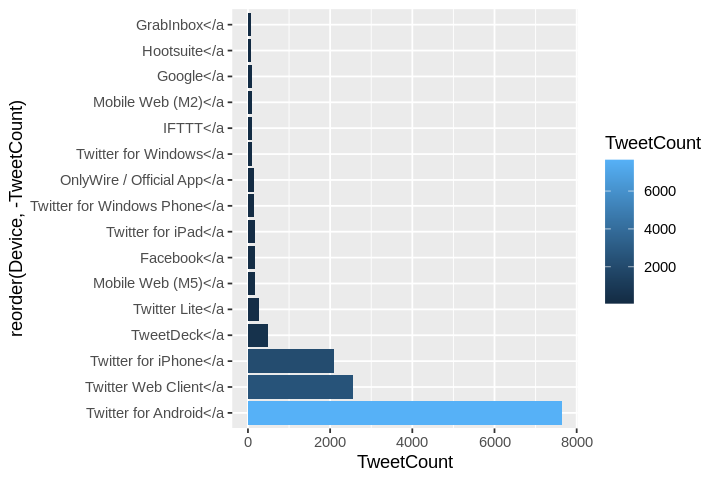

In [166]:
devices=tweetsdata$statusSource
devices <- gsub("","", devices)
devices <- strsplit(devices, ">")
devices <- sapply(devices,function(x) ifelse(length(x) > 1, x[2], x[1]))

devices_source=as.data.frame(table(devices))
colnames(devices_source)=c("Device","TweetCount")
devices_source=devices_source[devices_source$TweetCount>50,]
devices_source=devices_source[order(-devices_source$TweetCount),]

ggplot(devices_source,aes(x=reorder(Device, -TweetCount),y=TweetCount,fill=TweetCount))+geom_bar(stat='identity') +coord_flip()

The above chart shows that tweet volume from Android Phones is much higher than any other device. This is expected in a country like India as Android has a huge user base in India and IPhones and Windows Phone do not have a high penetration in the market.  Interestingly, the number of tweets from Android phones is also much higher than number of tweets from Web Client(Desktop). Android accounts for more than 50% of the overall tweets.

Most Popular Users
------------------

Uers whose tweets were retweeted most often:

In [167]:
y=ddply(tweetsdata, .(screenName), numcolwise(sum))
popularUsers=y[,c("screenName","retweetCount","tweet")]
popularUsers=popularUsers[order(-popularUsers$retweetCount),]
popularUsers=head(popularUsers,n=10)
popularUsers

screenName      retweetCount tweet
1141 apoliceshanigm2 7677          2   
5166 Krishna20977027 7677          2   
7012 ParthPa07241800 5916         13   
135  1SunnyElias     5170          1   
8020 rayyat9tfoi     5170          1   
9692 subhashjsr      5170          1   
9942 sxP6DbxfufguCc0 5170          1   
8509 sainath_kits    4280         11   
8487 SahilBalu456    3772          2   
9850 SurenderBalu1   3772          2

Users whose tweets generated most replies:



In [168]:
#Most Replies
Replies=tweetsdata[is.na(tweetsdata$replyToSN)==FALSE,]
y=ddply(Replies, .(replyToSN), numcolwise(sum))
Replies=y[,c("replyToSN","tweet")]
Replies=Replies[order(-Replies$tweet),]
Replies=head(Replies,n=10)
colnames(Replies)=c("User","RepliesReceived")
Replies


User            RepliesReceived
369 narendramodi    77             
421 PMOIndia        21             
518 sardesairajdeep 17             
66  ArvindKejriwal  16             
114 centerofright   13             
377 ndtv            12             
49  ANI_news        10             
608 timesofindia    10             
125 CNNnews18        9             
180 evanspiegel      9

At the top of the list is Narendra Modi, the Prime Minister of the Country, also see other twitter handles from the government such as PMO India and arunjaitley at the top of the list.

The other popular twitter handles belong to opposition leaders like ArvindKejriwal and NitishKumar. Media channels and journalists also feature in the list.

Sentiment Analysis
------------------

Using the syuzhet package to perform an overall sentiment analysis on the tweets related to demonetization.

In [169]:
tweetsdata$text<-gsub('\\p{So}|\\p{Cn}', '', tweetsdata$text, perl = TRUE)
tweetsdata$text<-gsub("(RT|via)((?:\\b\\w*@\\w+)+)","",tweetsdata$text)
tweetsdata$text<-gsub("http[^[:blank:]]+","",tweetsdata$text)
tweetsdata$text<-gsub("@\\w+","",tweetsdata$text)
tweetsdata$text<-gsub("[[:punct:]]"," ",tweetsdata$text)
tweetsdata$text<-gsub("[^[:alnum:]]"," ",tweetsdata$text)
tweetsdata$text<-gsub("\\w*[0-9]+\\w*\\s*","",tweetsdata$text)


In [170]:
tweets = tweetsdata

In [171]:
head(tweetsdata, n=10)

X.1 X 
1   1   1
2   2   2
3   3   3
4   4   4
5   5   5
6   6   6
7   7   7
8   8   8
9   9   9
10 10  10
   text                                                                                                                                
1  RT   Critical question  Was PayTM informed about  Demonetization edict by PM  It s clearly fishy and requires full disclosure  amp  
2  RT   Did you vote on  Demonetization on Modi survey app                                                                             
3  RT   Former FinSec  RBI Dy Governor  CBDT Chair   Harvard Professor lambaste  Demonetization   If not for Aam Aadmi  listen to th   
4  RT   Gurugram  Haryana   Post office employees provide cash exchange to patients in hospitals  demonetization                       
5  RT   Reddy Wedding   cartoon  demonetization  ReddyWedding                                                                          
6    India s  demonetization   Blackmoney a symptom  not the disease  via                                                              
7  RT   Rs lakh looted from a bank in Kishtwar in J amp K  Third such incident since  demonetization  That s how terrorists have       
8  RT   Calling all Nationalists to join    Walk for  CorruptionFreeIndia and spread the benefits of  Demonetization among the mas     
9  RT   Many opposition leaders are with  on the  Demonetization  And respect their decision but support oppositio                     
10 National reform now destroyed even the essence of sagan  Such instances urge giving  demonetization a second though                 
   favorited favoriteCount replyToSN      created             truncated
1  FALSE     0             NA             2016-11-23 18:40:30 FALSE    
2  FALSE     0             NA             2016-11-23 18:40:29 FALSE    
3  FALSE     0             NA             2016-11-23 18:40:03 FALSE    
4  FALSE     0             NA             2016-11-23 18:39:59 FALSE    
5  FALSE     0             NA             2016-11-23 18:39:39 FALSE    
6  FALSE     0             DerekScissors1 2016-11-23 18:39:11 FALSE    
7  FALSE     0             NA             2016-11-23 18:38:53 FALSE    
8  FALSE     0             NA             2016-11-23 18:38:20 FALSE    
9  FALSE     0             NA             2016-11-23 18:38:09 FALSE    
10 FALSE     0             NA             2016-11-23 18:38:00  TRUE    
   replyToSID id           ⋯
1  NA         8.014957e+17 ⋯
2  NA         8.014957e+17 ⋯
3  NA         8.014955e+17 ⋯
4  NA         8.014955e+17 ⋯
5  NA         8.014954e+17 ⋯
6  NA         8.014953e+17 ⋯
7  NA         8.014952e+17 ⋯
8  NA         8.014951e+17 ⋯
9  NA         8.014951e+17 ⋯
10 NA         8.014950e+17 ⋯
   statusSource                                                                        
1  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>
2  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>
3  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>
4  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>
5  <a href="http://cpimharyana.com" rel="nofollow">CPIMBadli</a>                       
6  <a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                  
7  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>
8  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>
9  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>
10 <a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M5)</a>             
   screenName      retweetCount isRetweet retweeted created_date hour
1  HASHTAGFARZIWAL 331           TRUE     FALSE     2016-11-23   18  
2  PRAMODKAUSHIK9   66           TRUE     FALSE     2016-11-23   18  
3  rahulja13034944  12           TRUE     FALSE     2016-11-23   18  
4  deeptiyvd       338           TRUE 

In [172]:
word.df <- as.vector(tweets$text)
emotion.df <- get_nrc_sentiment(word.df)
emotion.df2 <- cbind(tweets$text, emotion.df)

In [173]:
sent.value <- get_sentiment(word.df)
most.positive <- word.df[sent.value == max(sent.value)]
most.positive

[1] "RT    ed  U U ed  U U Please Include World Class Milkbar AMUL  amp  Baroda Dairy s Nutritious  Products to Promote Agriculture Priority Sector a "

In [174]:
most.negative <- word.df[sent.value <= min(sent.value)]
most.negative

[1] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
 [2] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
 [3] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
 [4] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
 [5] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
 [6] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
 [7] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
 [8] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
 [9] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[10] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[11] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[12] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[13] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[14] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[15] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[16] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[17] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[18] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[19] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[20] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[21] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[22] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[23] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[24] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[25] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[26] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[27] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[28] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[29] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[30] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[31] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[32] "RT    demonetization  bulletin  Severe liquidity crisis continues  Dire shortage of Reconfigured ATMs useless bcoz   "
[

In [175]:
positive.tweets <- word.df[sent.value > 0]
head(positive.tweets)

[1] "RT   Gurugram  Haryana   Post office employees provide cash exchange to patients in hospitals  demonetization "                  
[2] "RT   Calling all Nationalists to join    Walk for  CorruptionFreeIndia and spread the benefits of  Demonetization among the mas "
[3] "RT   Many opposition leaders are with  on the  Demonetization  And respect their decision but support oppositio "                
[4] "Many opposition leaders are with  on the  Demonetization  And respect their decision but support opposition just b coz of party" 
[5] "RT   Question in Narendra Modi App where PM is taking feedback if people support his  DeMonetization strategy "                  
[6] "RT    Demonetization The co operative banking sector in Kerala is as good as a tax haven  Is Kerala a Black Money HQ  "

In [176]:
negative.tweets <- word.df[sent.value<0]
head(negative.tweets)

[1] "RT   Critical question  Was PayTM informed about  Demonetization edict by PM  It s clearly fishy and requires full disclosure  amp  "
[2] "RT   Former FinSec  RBI Dy Governor  CBDT Chair   Harvard Professor lambaste  Demonetization   If not for Aam Aadmi  listen to th "  
[3] "  India s  demonetization   Blackmoney a symptom  not the disease  via "                                                             
[4] "RT   Rs lakh looted from a bank in Kishtwar in J amp K  Third such incident since  demonetization  That s how terrorists have "      
[5] "National reform now destroyed even the essence of sagan  Such instances urge giving  demonetization a second though  "               
[6] " Bharat band on ed  U U ed  U U Those who  are protesting  demonetization  are all different party leaders "

In [177]:
neutral.tweets <- word.df[sent.value ==0]
head(neutral.tweets)

[1] "RT   Did you vote on  Demonetization on Modi survey app "                                                                          
[2] "RT   Reddy Wedding   cartoon  demonetization  ReddyWedding "                                                                       
[3] "RT   The effect of  Demonetization      "                                                                                          
[4] "RT   When I explained  Demonetization to myself and tried to put it down in my words which are not laced with any heavy technical "
[5] "RT   BEFORE and AFTER Gandhi ji heard they are standing there against  Demonetization   "                                          
[6] "RT   Did you vote on  Demonetization on Modi survey app "

In [178]:
syuzhet <- get_sentiment(word.df, method="syuzhet")
bing <- get_sentiment(word.df, method="bing")
afinn <- get_sentiment(word.df, method="afinn")
nrc <- get_sentiment(word.df, method="nrc")
sentiments <- data.frame(syuzhet, bing, afinn, nrc, tweetsdata$created)

In [179]:
emotions <- get_nrc_sentiment(word.df)
emo_bar = colSums(emotions)
emo_sum = data.frame(count=emo_bar, emotion=names(emo_bar))
emo_sum$emotion = factor(emo_sum$emotion, levels=emo_sum$emotion[order(emo_sum$count, decreasing = TRUE)])

In [180]:
install.packages("plotly")
library(plotly)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [181]:
#tweetSentiment <- get_nrc_sentiment(some_txt)

barplot(
  sort(colSums(prop.table(emotion.df[, 1:8]))), 
#  horiz = TRUE, 
  cex.names = 0.7, 
  las = 1, 
  main = "Emotions in Tweets text", xlab="Percentage"
)

In [182]:
tweets = subset(tweets, select = -c(X.1,favorited,favoriteCount) )
head(tweets)

X
1 1
2 2
3 3
4 4
5 5
6 6
  text                                                                                                                                
1 RT   Critical question  Was PayTM informed about  Demonetization edict by PM  It s clearly fishy and requires full disclosure  amp  
2 RT   Did you vote on  Demonetization on Modi survey app                                                                             
3 RT   Former FinSec  RBI Dy Governor  CBDT Chair   Harvard Professor lambaste  Demonetization   If not for Aam Aadmi  listen to th   
4 RT   Gurugram  Haryana   Post office employees provide cash exchange to patients in hospitals  demonetization                       
5 RT   Reddy Wedding   cartoon  demonetization  ReddyWedding                                                                          
6   India s  demonetization   Blackmoney a symptom  not the disease  via                                                              
  replyToSN      created             truncated replyToSID id          
1 NA             2016-11-23 18:40:30 FALSE     NA         8.014957e+17
2 NA             2016-11-23 18:40:29 FALSE     NA         8.014957e+17
3 NA             2016-11-23 18:40:03 FALSE     NA         8.014955e+17
4 NA             2016-11-23 18:39:59 FALSE     NA         8.014955e+17
5 NA             2016-11-23 18:39:39 FALSE     NA         8.014954e+17
6 DerekScissors1 2016-11-23 18:39:11 FALSE     NA         8.014953e+17
  replyToUID
1         NA
2         NA
3         NA
4         NA
5         NA
6 2586266100
  statusSource                                                                        
1 <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>
2 <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>
3 <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>
4 <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>
5 <a href="http://cpimharyana.com" rel="nofollow">CPIMBadli</a>                       
6 <a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                  
  screenName      retweetCount isRetweet retweeted created_date hour
1 HASHTAGFARZIWAL 331           TRUE     FALSE     2016-11-23   18  
2 PRAMODKAUSHIK9   66           TRUE     FALSE     2016-11-23   18  
3 rahulja13034944  12           TRUE     FALSE     2016-11-23   18  
4 deeptiyvd       338           TRUE     FALSE     2016-11-23   18  
5 CPIMBadli       120           TRUE     FALSE     2016-11-23   18  
6 ambazaarmag       0          FALSE     FALSE     2016-11-23   18  
  isRetweetNum retweetedNum tweet
1 1            0            1    
2 1            0            1    
3 1            0            1    
4 1            0            1    
5 1            0            1    
6 0            0            1

In [183]:
head(tweets)

X
1 1
2 2
3 3
4 4
5 5
6 6
  text                                                                                                                                
1 RT   Critical question  Was PayTM informed about  Demonetization edict by PM  It s clearly fishy and requires full disclosure  amp  
2 RT   Did you vote on  Demonetization on Modi survey app                                                                             
3 RT   Former FinSec  RBI Dy Governor  CBDT Chair   Harvard Professor lambaste  Demonetization   If not for Aam Aadmi  listen to th   
4 RT   Gurugram  Haryana   Post office employees provide cash exchange to patients in hospitals  demonetization                       
5 RT   Reddy Wedding   cartoon  demonetization  ReddyWedding                                                                          
6   India s  demonetization   Blackmoney a symptom  not the disease  via                                                              
  replyToSN      created             truncated replyToSID id          
1 NA             2016-11-23 18:40:30 FALSE     NA         8.014957e+17
2 NA             2016-11-23 18:40:29 FALSE     NA         8.014957e+17
3 NA             2016-11-23 18:40:03 FALSE     NA         8.014955e+17
4 NA             2016-11-23 18:39:59 FALSE     NA         8.014955e+17
5 NA             2016-11-23 18:39:39 FALSE     NA         8.014954e+17
6 DerekScissors1 2016-11-23 18:39:11 FALSE     NA         8.014953e+17
  replyToUID
1         NA
2         NA
3         NA
4         NA
5         NA
6 2586266100
  statusSource                                                                        
1 <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>
2 <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>
3 <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>
4 <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>
5 <a href="http://cpimharyana.com" rel="nofollow">CPIMBadli</a>                       
6 <a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                  
  screenName      retweetCount isRetweet retweeted created_date hour
1 HASHTAGFARZIWAL 331           TRUE     FALSE     2016-11-23   18  
2 PRAMODKAUSHIK9   66           TRUE     FALSE     2016-11-23   18  
3 rahulja13034944  12           TRUE     FALSE     2016-11-23   18  
4 deeptiyvd       338           TRUE     FALSE     2016-11-23   18  
5 CPIMBadli       120           TRUE     FALSE     2016-11-23   18  
6 ambazaarmag       0          FALSE     FALSE     2016-11-23   18  
  isRetweetNum retweetedNum tweet
1 1            0            1    
2 1            0            1    
3 1            0            1    
4 1            0            1    
5 1            0            1    
6 0            0            1

In [184]:
write.csv(tweets,"tweets.csv", row.names = FALSE)


The most dominant emotion expressed in the tweets is trust, Also there was fear related to the uncertainty and problems it would cause in the country. A significant percentage of people also showed emotions of disgust, sadness and anger in their tweets.

